In [14]:
import pandas as pd

import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
matplotlib.rcParams['timezone'] = 'Europe/Berlin'

import data_process_base
import importlib
importlib.reload(data_process_base)

try:
    import seaborn
    colors = seaborn.color_palette()
except:
    colors = ["b", "g", "r", "c", "y"]

In [15]:
"""
Data processing for power flow time-step iteration

"""

# create random time series from import data
da = data_process_base.DataAction()
keep_cols = ['DE_KN_residential1_grid_import',
             'DE_KN_residential2_grid_import',
             'cet_cest_timestamp']
da.imp_procc("house_data.csv", keep_cols)
night_merge = da.power_merge()

Number of data frame segments =  90
dfList created successfully.
Whoops, grabbing a different touple of dates...
Whoops, grabbing a different touple of dates...
Whoops, grabbing a different touple of dates...


In [16]:
# # for testing the sgen_comm function
# test = night_merge.iloc[:9,:].copy()
# da.sgen_comm(ts=test, wind_length=2, sgen_val=999999, parties=4)

In [55]:
# assign generator value at random times
sgen_val = 0.01 # typical val: 0.010 MW = 10kW
night_mw = da.sgen_comm(ts=night_merge, wind_length=60, sgen_val=0.010, parties=4)

# replace index for pandapower controller module
test_set = night_mw.copy()
test_set.index = range(0, test_set.shape[0])
test_set.head()

# night_mw.rolling(3).sum().plot()

,load_1,sgen_1,load_2,sgen_2,load_3,sgen_3,load_4,sgen_4
0,0.014648,0.0,0.006152,0.0,0.008789,0.0,0.006152,0.0
1,0.014648,0.0,0.006152,0.0,0.008789,0.0,0.006152,0.0
2,0.029883,0.0,0.000000,0.0,0.018164,0.0,0.000000,0.0
3,0.015234,0.0,0.005859,0.0,0.009375,0.0,0.005859,0.0
4,0.015234,0.0,0.005859,0.0,0.009375,0.0,0.005859,0.0


<AxesSubplot:xlabel='date_time'>

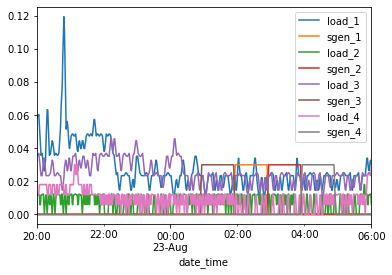

In [56]:
night_mw.rolling(3).sum().plot()